# Data Analysis notebook (3) only for velib_data.csv  (taken from velib database) 

### Summary:
- 1) A first look at our dataset with ydata-profile (only a quick summary of the dataset)
- 2) Visualization of our dataset (Discovery of our dataset...  )
- 3) How to handle missing values ? (Replace them, Predict them)
- 4) Deal with highly correlated variables (correlation matrix, PCA)
- 5) All the changes we made in order to transform the initial velib dataset to make a new one: velib_processed.csv

-----------------------------------------------------------------------------------------------

We begin by importing the necessary packages

In [56]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import folium
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

-----------------------------------------------------------------------------------------------
#### 1) A first look at our dataset with ydata-profile

In [57]:
#Load the velib dataset
data_velib = pd.read_csv("data/velib_data.csv",sep=";")

The below report sums up key elements we need to know for the velib data

In [58]:
# Generate a minimal profile report
profile = ProfileReport(data_velib,minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------------
#### 2) Visualization of our dataset (Discovery of our dataset...  )

In [59]:
data_velib.head()

,Identifiant station,Nom station,Station en fonctionnement,Capacité de la station,Nombre bornettes libres,Nombre total vélos disponibles,Vélos mécaniques disponibles,Vélos électriques disponibles,Borne de paiement disponible,Retour vélib possible,Actualisation de la donnée,Coordonnées géographiques,Nom communes équipées,Code INSEE communes équipées
0,16107,Benjamin Godard - Victor Hugo,OUI,35,29,6,2,4,OUI,OUI,2023-11-22T09:24:31+01:00,"48.865983, 2.275725",Paris,NaN
1,14111,Cassini - Denfert-Rochereau,OUI,25,15,9,6,3,OUI,OUI,2023-11-22T09:24:22+01:00,"48.837525839067, 2.3360354080796",Paris,NaN
2,9020,Toudouze - Clauzel,OUI,21,19,2,2,0,OUI,OUI,2023-11-22T09:25:05+01:00,"48.87929591733507, 2.3373600840568547",Paris,NaN
3,12109,Mairie du 12ème,OUI,30,26,1,0,1,OUI,OUI,2023-11-22T09:20:38+01:00,"48.840855311763, 2.3875549435616",Paris,NaN
4,8026,Messine - Place Du Pérou,OUI,12,0,9,5,4,OUI,OUI,2023-11-22T09:25:29+01:00,"48.875448033960744, 2.315508019010038",Paris,NaN


In [60]:
data_velib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Identifiant station             998 non-null    int64  
 1   Nom station                     998 non-null    object 
 2   Station en fonctionnement       998 non-null    object 
 3   Capacité de la station          998 non-null    int64  
 4   Nombre bornettes libres         998 non-null    int64  
 5   Nombre total vélos disponibles  998 non-null    int64  
 6   Vélos mécaniques disponibles    998 non-null    int64  
 7   Vélos électriques disponibles   998 non-null    int64  
 8   Borne de paiement disponible    998 non-null    object 
 9   Retour vélib possible           998 non-null    object 
 10  Actualisation de la donnée      998 non-null    object 
 11  Coordonnées géographiques       998 non-null    object 
 12  Nom communes équipées           998 

We see a lot of variables that we need to link with our initial train.parquet dataset and a lot that we need to remove (for example "Nom communes équipées" contains only Paris so is useless )

Visualizing the data

In [61]:
# Convert 'Actualisation de la donnée' to datetime format with timezone
data_velib['Actualisation de la donnée'] = pd.to_datetime(data_velib['Actualisation de la donnée'], errors='coerce', utc=True)

# Extract just the date part
data_velib['Date'] = data_velib['Actualisation de la donnée'].dt.date

# Drop rows where 'Date' is NaT (or NaN) if any
data_velib = data_velib.dropna(subset=['Date'])

# Now try finding the min and max dates again
min_date = data_velib['Date'].min()
max_date = data_velib['Date'].max()

# Output the min and max dates
print(min_date, max_date)

2018-04-11 2023-11-22


Now let's visualize the Average Daily Bikes Available in a random station in each arrondissement :

We need to first extract the arrondissement number from the 'Identifiant station' column. Then, group the data by arrondissement and calculate the average number of bikes. Here’s how we will do it :
- Extract Arrondissement Number: Create a new column in the DataFrame to store the arrondissement number extracted from the station identifier.
- Calculate Average by Arrondissement: Group the data by arrondissement and calculate the average number of available bikes.
- Create the Plot: Plot the graph with arrondissements on the x-axis and the average number of bikes on the y-axis.

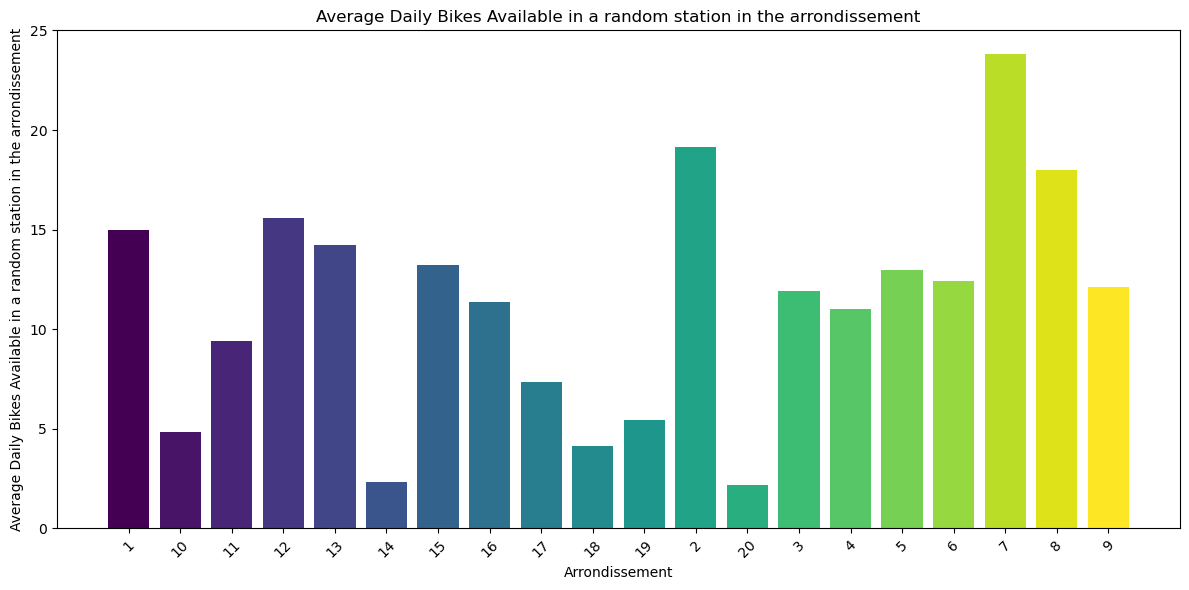

In [70]:
# Function to extract arrondissement number
def extract_arrondissement(identifiant):
    identifiant = str(identifiant)
    return identifiant[:2] if len(identifiant) == 5 else identifiant[0]

# Apply the function to create a new column 'Arrondissement'
data_velib['Arrondissement'] = data_velib['Identifiant station'].apply(extract_arrondissement)

# Calculate the daily average number of bikes available by arrondissement
average_bikes_per_arrondissement = data_velib.groupby('Arrondissement')['Nombre total vélos disponibles'].mean()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust the size as needed
colors = plt.cm.viridis(np.linspace(0, 1, len(average_bikes_per_arrondissement)))
plt.bar(average_bikes_per_arrondissement.index, average_bikes_per_arrondissement, color=colors)

# Add titles and labels
plt.title('Average Daily Bikes Available in a random station in each arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Average Daily Bikes Available')

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()
